In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import random
import os
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import cv2
import os

In [2]:
df_train = pd.read_csv('./input/train.csv')

In [3]:
df_train.shape

(22184, 2)

In [4]:
df_label_split = df_train['Image_Label'].str.split('_', expand = True)
df_label_split.columns = ["Filename", "ClassId"]
df_label_split.head()

,Filename,ClassId
0,0011165.jpg,Fish
1,0011165.jpg,Flower
2,0011165.jpg,Gravel
3,0011165.jpg,Sugar
4,002be4f.jpg,Fish


In [5]:
df_train['Defect'] = df_train['EncodedPixels'].notnull()
df_train = df_train[['Image_Label', 'Defect','EncodedPixels']]
df_train.head()

,Image_Label,Defect,EncodedPixels
0,0011165.jpg_Fish,True,264918 937 266318 937 267718 937 269118 937 27...
1,0011165.jpg_Flower,True,1355565 1002 1356965 1002 1358365 1002 1359765...
2,0011165.jpg_Gravel,False,NaN
3,0011165.jpg_Sugar,False,NaN
4,002be4f.jpg_Fish,True,233813 878 235213 878 236613 878 238010 881 23...


In [6]:
df_train = pd.concat([df_train, df_label_split], axis=1, sort=False)
df_train = df_train.drop(['Image_Label'], axis=1)
df_train.head()

,Defect,EncodedPixels,Filename,ClassId
0,True,264918 937 266318 937 267718 937 269118 937 27...,0011165.jpg,Fish
1,True,1355565 1002 1356965 1002 1358365 1002 1359765...,0011165.jpg,Flower
2,False,NaN,0011165.jpg,Gravel
3,False,NaN,0011165.jpg,Sugar
4,True,233813 878 235213 878 236613 878 238010 881 23...,002be4f.jpg,Fish


In [7]:
df_train = df_train[df_train.Defect]
df_train = df_train.drop(['Defect'], axis=1)
df_train = df_train[['Filename', 'ClassId', 'EncodedPixels']]
df_train.head(10)

,Filename,ClassId,EncodedPixels
0,0011165.jpg,Fish,264918 937 266318 937 267718 937 269118 937 27...
1,0011165.jpg,Flower,1355565 1002 1356965 1002 1358365 1002 1359765...
4,002be4f.jpg,Fish,233813 878 235213 878 236613 878 238010 881 23...
5,002be4f.jpg,Flower,1339279 519 1340679 519 1342079 519 1343479 51...
7,002be4f.jpg,Sugar,67495 350 68895 350 70295 350 71695 350 73095 ...
8,0031ae9.jpg,Fish,3510 690 4910 690 6310 690 7710 690 9110 690 1...
9,0031ae9.jpg,Flower,2047 703 3447 703 4847 703 6247 703 7647 703 9...
11,0031ae9.jpg,Sugar,658170 388 659570 388 660970 388 662370 388 66...
13,0035239.jpg,Flower,100812 462 102212 462 103612 462 105012 462 10...
14,0035239.jpg,Gravel,65400 380 66800 380 68200 380 69600 380 71000 ...


In [8]:
from sklearn.preprocessing import LabelEncoder

# instantiate labelencoder object
le = LabelEncoder()
df_train['ClassId'] = le.fit_transform(df_train['ClassId'])
df_train.head(10)

,Filename,ClassId,EncodedPixels
0,0011165.jpg,0,264918 937 266318 937 267718 937 269118 937 27...
1,0011165.jpg,1,1355565 1002 1356965 1002 1358365 1002 1359765...
4,002be4f.jpg,0,233813 878 235213 878 236613 878 238010 881 23...
5,002be4f.jpg,1,1339279 519 1340679 519 1342079 519 1343479 51...
7,002be4f.jpg,3,67495 350 68895 350 70295 350 71695 350 73095 ...
8,0031ae9.jpg,0,3510 690 4910 690 6310 690 7710 690 9110 690 1...
9,0031ae9.jpg,1,2047 703 3447 703 4847 703 6247 703 7647 703 9...
11,0031ae9.jpg,3,658170 388 659570 388 660970 388 662370 388 66...
13,0035239.jpg,1,100812 462 102212 462 103612 462 105012 462 10...
14,0035239.jpg,2,65400 380 66800 380 68200 380 69600 380 71000 ...


In [10]:
df_train.shape

(11836, 3)

### Utility functions

In [13]:
# This function uses a 0 based start index (arrays, matrixes and imgs start a index 0)
def mask2rle(img):
    tmp = np.rot90( np.flipud( img ), k=3 )
    rle = []
    lastColor = 0;
    startpos = 0
    endpos = 0

    tmp = tmp.reshape(-1,1)   
    
    for i in range( len(tmp) ):
        if (lastColor==0) and tmp[i]>0:
            startpos = i
            lastColor = 1
        elif (lastColor==1)and(tmp[i]==0):
            endpos = i-1
            lastColor = 0
            rle.append( str(startpos)+' '+str(endpos-startpos+1) )
    return " ".join(rle)

In [14]:
img = [
    [0, 1, 0, 0, 0],
    [0, 1, 1, 1, 0], 
    [0, 1, 0, 1, 0],
    [0, 1, 1, 1, 0], 
    [0, 0, 0, 1, 0],
]

res = mask2rle(img)
print(res)

5 4 11 1 13 1 16 4


In [15]:
# This function uses a 0 based start index (arrays, matrixes and imgs start a index 0)
def rle2mask(rle, imgshape=(1600,256)):
    width = imgshape[0]
    height= imgshape[1]
    
    mask= np.zeros( width*height ).astype(np.uint8)
    
    array = np.asarray([int(x) for x in rle.split()])
    starts = array[0::2]
    lengths = array[1::2]

    current_position = 0
    for index, start in enumerate(starts):
        mask[int(start):int(start+lengths[index])] = 1
        current_position += lengths[index]
        
    return np.flipud( np.rot90( mask.reshape(height, width), k=1 ) )

In [16]:
res = rle2mask("5 4 11 1 13 1 16 4", (5, 5))
print(res)

[[0 1 0 0 0]
 [0 1 1 1 0]
 [0 1 0 1 0]
 [0 1 1 1 0]
 [0 0 0 1 0]]


In [19]:
# This function uses a 1 based start index (arrays, matrixes and imgs start a index 1)
def rle2mask_eda(mask_rle, shape=(1600,256)):
    '''
    mask_rle: run-length as string formated (start length)
    shape: (width,height) of array to return 
    Returns numpy array, 1 - mask, 0 - background

    '''
    s = mask_rle.split()
    starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]
    starts -= 1
    ends = starts + lengths
    img = np.zeros(shape[0]*shape[1], dtype=np.uint8)
    for lo, hi in zip(starts, ends):
        img[lo:hi] = 1
    return img.reshape(shape).T

In [20]:
res = rle2mask_eda("6 4 12 1 14 1 17 4", (5, 5))
print(res)

[[0 1 0 0 0]
 [0 1 1 1 0]
 [0 1 0 1 0]
 [0 1 1 1 0]
 [0 0 0 1 0]]


#### back to the data

In [28]:
df_train['EncodedPixels'].iloc[1]

'1355565 1002 1356965 1002 1358365 1002 1359765 1002 1361165 1002 1362565 1002 1363965 1002 1365365 1002 1366765 1002 1368165 1002 1369565 1002 1370965 1002 1372365 1002 1373765 1002 1375165 1002 1376565 1002 1377965 1002 1379365 1002 1380765 1002 1382165 1002 1383565 1002 1384965 1002 1386365 1002 1387765 1002 1389165 1002 1390565 1002 1391965 1002 1393365 1002 1394765 1002 1396165 1002 1397565 1002 1398965 1002 1400365 1002 1401765 1002 1403165 1002 1404565 1002 1405965 1002 1407365 1002 1408765 1002 1410165 1002 1411565 1002 1412965 1002 1414365 1002 1415765 1002 1417165 1002 1418565 1002 1419965 1002 1421365 1002 1422765 1002 1424165 1002 1425565 1002 1426965 1002 1428365 1002 1429765 1002 1431165 1002 1432565 1002 1433965 1002 1435365 1002 1436765 1002 1438165 1002 1439565 1002 1440965 1002 1442365 121 1442487 880 1443765 1002 1445165 1002 1446565 1002 1447965 1002 1449365 1002 1450765 1002 1452165 1002 1453565 1002 1454965 1002 1456365 1002 1457765 1002 1459165 1002 1460565 1002 

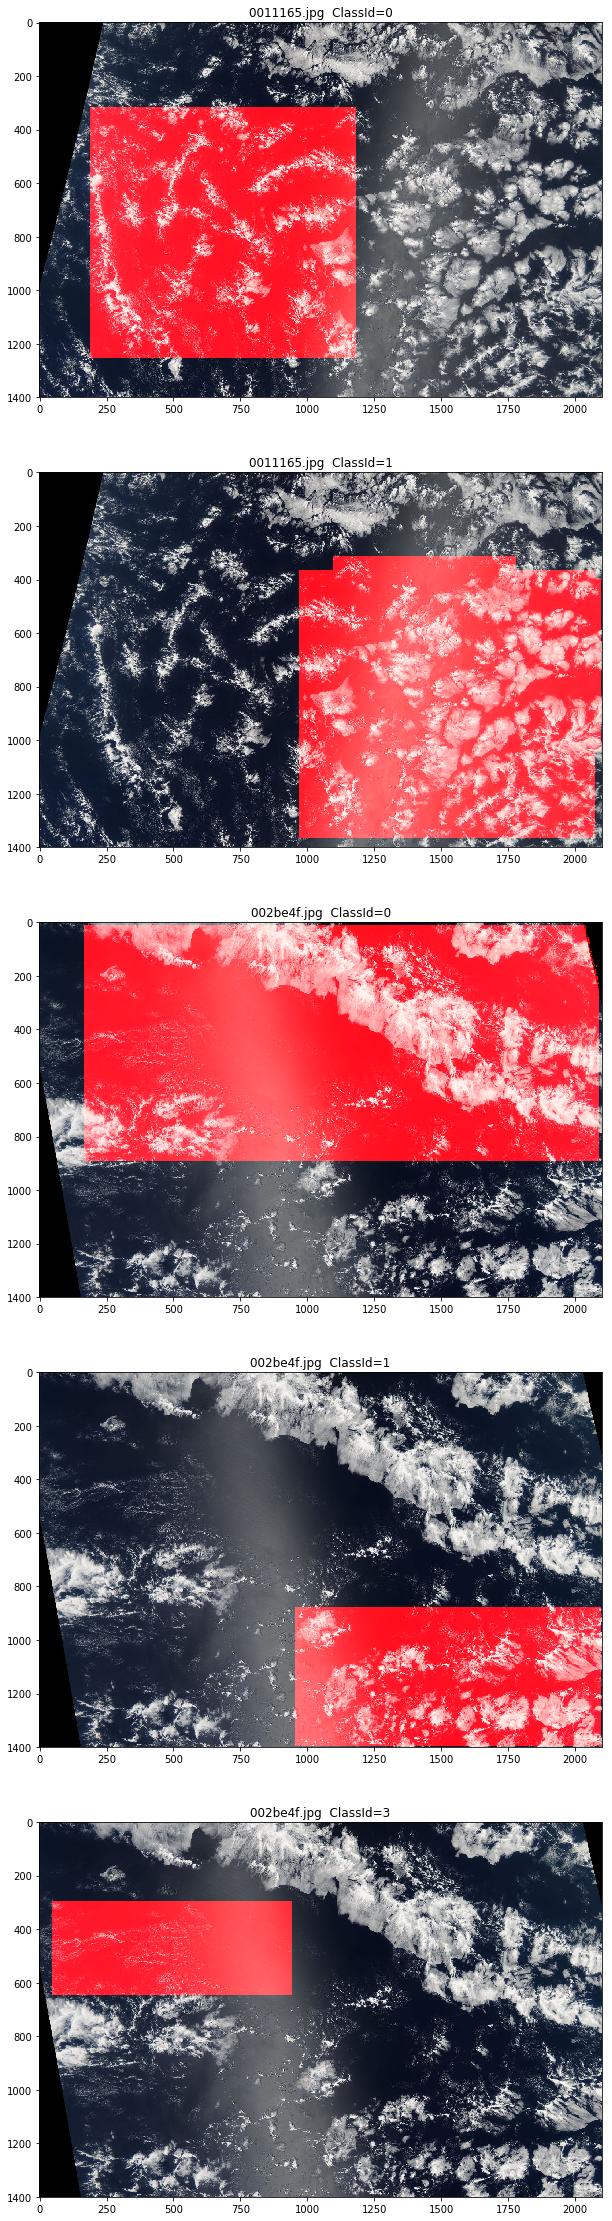

In [34]:
rows = 5
fig = plt.figure(figsize=(40, 40))
for i in range(0, rows):
    fn = df_train['Filename'].iloc[i]
    c = df_train['ClassId'].iloc[i]
    fig.add_subplot(rows, 1, i + 1).set_title(fn +"  ClassId=" + str(c))
    img = cv2.imread( './input/train_images/' + fn)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    mask = rle2mask(df_train['EncodedPixels'].iloc[i], img.shape)
    img[mask==1,0] = 255
    plt.imshow(img)
plt.show()